<a id="title_ID"></a>
# Beginner: Read and Display A TESS Target Pixel File

This notebook tutorial demonstrates how to load and display the contents of a TESS target pixel (tp) file.  We will display the flux values from a given cadence, and identify the pixels used in the photometric aperture.

In [1]:
%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

from photutils import aperture_photometry, RectangularAperture, RectangularAnnulus

## Introduction

A target pixel file contains the raw and calibrated fluxes for the pixels downloaded at a cadence shorter than the full frame images.  Nominally, these are at a two-minute cadence.  It also contains information about the aperture, including which pixels were used to calculate the total flux, which pixels were used to estimate the background flux, and which pixels were used to calculate the flux weighted or pixel response function centroids.  The data shown here will be for the star TIC 25155310, which is known to host at least one planet, WASP-126 b.

This tutorial will refer to a couple TESS-related terms that we define here.
* Sector = TESS observed the sky in regions of 24x96 degrees along the southern, then northern, ecliptic hemispheres.  Each of these regions is referred to as a "sector", starting with Sector 1.
* HDU = Header Data Unit.  A FITS file is made up of HDUs that contain data and metadata relating to the file. The first HDU is called the primary HDU, and anything that follows is considered an "extension", e.g., "the first FITS extension", "the second FITS extension", etc.
* BJD = Barycentric Julian Date, the Julian Date that has been corrected for differences in the Earth's position with respect to the Solar System center of mass.
* TBJD = TESS Barycentric Julian Date, the timestamp measured in BJD, but offset by 2457000.0.  I.e., TBJD = BJD - 2457000.0
* Cadence = The interval between flux measurements, nominally ~2 minutes for the target pixel files, and ~30 minutes for the full frame images.

## Obtaining The Target Pixel File

We will read the target pixel file from Sector 1 using the MAST URL location.  So that we can get started with understanding the file contents without reviewing how to automatically search for and retrieve TESS files, we won't show how to search and retrieve TESS target pixel files in this tutorial. Consult other TESS tutorials [in the TESS Archive Handbook](https://outerspace.stsci.edu/display/TESS/6.0+-+Data+Search+Tutorials) for much more information on how to search for TESS data using MAST services.

In [2]:
# For the purposes of this tutorial, we just know the MAST URL location of the file we want to examine.
fits_file = 'tess2019331140908-s0019-0000000392774261-0164-s_tp.fits'
# fits_file = "tess2019198215352-s0014-0000000233310793-0150-s_tp.fits"
# fits_file = "https://archive.stsci.edu/missions/tess/tid/s0001/0000/0000/2515/5310/tess2018206045859-s0001-0000000025155310-0120-s_tp.fits"

## Understanding The Target Pixel File Structure

The TESS target pixel files contain a primary HDU with metadata stored in the header.  The first extension HDU contains more metadata in the header and stores arrays of data in a binary FITS table, which include the timestamps, fluxes, and background fluxes for each cadence of the pixels read out and downloaded by the spacecraft.  The second extension HDU contains an image that stores the pixels that were read out, and records information such as which pixels were used in the optimal photometric aperture to create the SAP fluxes.  The third extension HDU is a placeholder and is not currently used by the mission:  it can be ignored.  Let's examine the structure of the FITS file using the astropy.fits `info` function, which shows the FITS file format in more detail.

In [3]:
fits.info(fits_file)

Filename: tess2019331140908-s0019-0000000392774261-0164-s_tp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  PIXELS        1 BinTableHDU    248   18052R x 11C   [D, E, J, 121J, 121E, 121E, 121E, 121E, J, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   
  3  TARGET COSMIC RAY    1 BinTableHDU     27   0R x 4C   [J, I, I, E]   


Let's examine the binary table in the first FITS extension, since that contains the arrays of timestamps and fluxes for each cadence.  We will use the astropy.fits `getdata` function to access the table from the first extension HDU, and then show the columns of the table.  We can see included in the table are columns for the timestamps in TESS BJD format (**TIME**), raw counts (**RAW_CNTS**), and calibrated fluxes (**FLUX**).

In [4]:
fits.getdata(fits_file, ext=1).columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'RAW_CNTS'; format = '121J'; unit = 'count'; null = -1; disp = 'I8'; dim = '(11,11)'
    name = 'FLUX'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'FLUX_ERR'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'FLUX_BKG'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'FLUX_BKG_ERR'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'POS_CORR1'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'POS_CORR2'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
)

If you examine the structure of the data, the table is more complicated than just rows and columns of values.  You can see the dimensions of the raw counts, flux, flux errors, flux backgrounds, and flux background errors are 11x11 (the size of the pixel stamp read out for this particular target).  We'll show how to examine the fluxes from a particular cadence below.

## Reading the timestamps and fluxes.

Now that we have the target pixel file, let's store the timestamps and fluxes for use later.

In [5]:
with fits.open(fits_file, mode="readonly") as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    raw_counts = hdulist[1].data['RAW_CNTS']
    calibrated_fluxes = hdulist[1].data['FLUX']

Let's examine one of these to see how Python stores the data.

In [6]:
print(type(calibrated_fluxes))
print(calibrated_fluxes.shape)

<class 'numpy.ndarray'>
(18052, 11, 11)


So these data are stored as a numpy array.  The first dimension is the number of cadences, followed by the size of the readout.  Thus, accessing `calibrated_fluxes[4,:,:]` should return to us the 11x11 grid of pixels from the **fifth** cadence (remember Python is zero-indexed, so the first cadence is stored in the zeroth index, the second in the first index, etc.)

In [7]:
calibrated_fluxes[4,:,:].shape

(11, 11)

## Show the calibrated pixel values.

Let's display the calibrated fluxes for one of the cadences in our target pixel file.  For now, we'll pick the fifth cadence (index number 4).  You could of course decide to look at multiple cadences by looping over each index in the first dimension of the structure (e.g., loop over `calibrated_fluxes[i,:,:]`).  You could even make an animated .gif of the fluxes and see how they change from cadence to cadence.  To get you started though, let's just display one of the cadence's flux values.

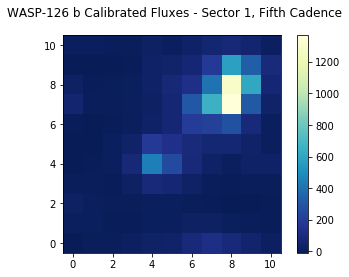

In [15]:
# Start figure and axis.
fig, ax = plt.subplots()

# Display the calibrated fluxes as an image for the fifth cadence.
cax = ax.imshow(calibrated_fluxes[1000,:,:], cmap=plt.cm.YlGnBu_r, origin="lower")

# Let's define a title for the figure.
fig.suptitle("WASP-126 b Calibrated Fluxes - Sector 1, Fifth Cadence")

# Add a color bar.
cbar = fig.colorbar(cax)
plt.show()

## Displaying The Aperture Pixel Information

Let's read in the second FITS extension HDU to display the aperture information.  First, let's read in the aperture pixels from the HDU.

In [16]:
with fits.open(fits_file, mode="readonly") as hdulist:
    aperture = hdulist[2].data

# Construct a custom aperture and annulus 
aperature = RectangularAperture((6,5), 3,3)
annulus_aperture = RectangularAnnulus((6,5), 4, 5, 5)
# Combine the aperture
aps = [aperature , annulus_aperture]

apx = 6
apy = 5
r = 1
ap_im = np.zeros(calibrated_fluxes[4,:,:].shape)
ap_im[apx-r:apx+r, apy-r:apy+r] = 1
ap_ann_im = np.zeros(calibrated_fluxes[4,:,:].shape)
# phot_table = aperture_photometry(calibrated_fluxes[4,:,:], aps)

Let's plot the pixels as an image.

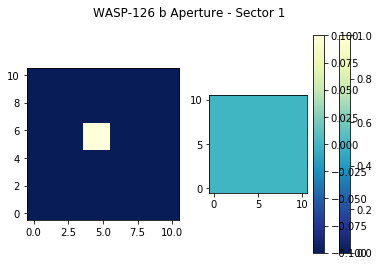

In [17]:
# Start figure and axis.
fig, axs = plt.subplots(1, 2)
# Remove horizontal space between axes
#plt.axis('equal')

fig.suptitle('Apertures', fontsize=14 )
(ax1, ax2) = axs
# fig, ax1, ax2 = plt.subplots()

# Display the pixels as an image.
cax1 = ax1.imshow(ap_im, cmap=plt.cm.YlGnBu_r, origin="lower")
cax2 = ax2.imshow(ap_ann_im, cmap=plt.cm.YlGnBu_r, origin="lower")
# Add a color bar.
cbar1 = fig.colorbar(cax1)
cbar2 = fig.colorbar(cax2)

# Add a title to the plot.
fig.suptitle("WASP-126 b Aperture - Sector 1")
plt.show()

## Understanding The Aperture Pixel Values

We see the pixel values are integers, but what do they mean?  The pixels are bitmasks that encode information about each pixel.  You can find a summary of what the different values mean [here](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview#id-2.0-DataProductOverview-Table:ApertureMaskImageFlags).  For example, a pixel in the aperture that might have a value of 57 can be broken down into power of 2 like: 32+16+8+1 = 57.  Referencing the table of values, this means this particular pixel was in CCD Output A, was used to calculate the PRF centroid, was used to calculate the flux weighted centroid, and was collected by the spacecraft.  Numpy has a bulit-in function that can convert an integer into a binary bit mask.  Let's use that now one one of the common values we see in our displayed image above.

In [18]:
# Break down a pixel value of 267 (yellow pixels displayed above) into its constituent bits.
bits = np.binary_repr(267)
print(bits)

100001011


Binary bits start from the right and end at the left, so the bit farthest on the right is the Least Significant Bit (LSB, equal to 2^0 = 1), the second from the right is 2^1=2, the third from the right is 2^2=4, etc. This bit mask has bit values of 1 (2^0), 2 (2^1), 8 (2^3), and 256 (2^8) set. From our look-up table, these values mean the pixels have been: collected by the spacecraft (value = 1), used in the optimal photometric aperture (value = 2), used to calculate the flux-weighted centroid (value = 8), and are on CCD Output D (value = 256).

## Marking All Pixels Used In The Photometric Aperture

Let's display the pixels in the aperture FITS extension again, but this time, let's only mark those that are used in the optimal photometric aperture (bit mask value of 2 set).  While it is possible to do this in fewer lines, we'll show more of the steps involved for clarity.

In [19]:
# Create an array that will keep track of which pixels have a bitmask
# value of 2 set. To start, everything is set to 0 = not set.  We make it
# the same dimension as the aperture pixel table, for clarity.
bitmask2_set = np.zeros(aperture.shape)

# Identify which pixels have the bit mask value of 2 set.  We'll first
# loop over each row (i) in the 11x11 table, and then each column (j).
for i,row in enumerate(aperture):
    for j, pix in enumerate(row):

        # Get the bitmask as a string of zeros and ones.
        this_bitmask = np.binary_repr(pix)

        # Is the bitmask value of 2 set?  If so, the 2nd integer from the
        # right should be set to 1.  We'll use Python negative indexes to
        # access the second integer from the right.
        if this_bitmask[-2] == '1':
            
            # Then record this pixel as having a bitmask value of 2 set.
            bitmask2_set[i,j] = 1

Now we can display the aperture, but this time we will only display the bitmask2_set table we've created, where a zero means the bitmask value of 2 is NOT set (thus these pixels aren't used in the optimal photometric aperture) and a one means the bitmask value of 2 is set (and thus these pixels were used in the optimal photometric aperture).

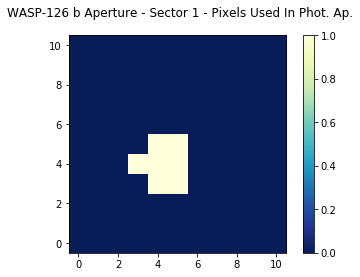

In [20]:
# Start figure and axis.
fig, ax = plt.subplots()

# Display, as an image, the 11x11 table that records the bitmask value of 2 being set.
cax = ax.imshow(bitmask2_set, cmap=plt.cm.YlGnBu_r, origin="lower")

# Add a color bar.
cbar = fig.colorbar(cax)

# Add a title to the plot.
fig.suptitle("WASP-126 b Aperture - Sector 1 - Pixels Used In Phot. Ap.")
plt.show()

## About this Notebook

**Author:** Scott W. Fleming, STScI Archive Scientist

**Updated On:** 2018-11-21

[Top of Page](#title_ID)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="STScI logo" width="200px"/> 